This code is designed to retrieve surface information from input A-D image files and given instrument response parameters

In [59]:
# Generic imports
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
import PIL
import copy
from scipy.interpolate import griddata
from scipy.special import gamma
import scipy.optimize as optimization
import os

# Reloading
from importlib import reload

# Local imports
import sys
sys.path.append('../../../')
import stlstuff as sls
import imagestuff as ims
import facetbrightnessstuff9 as fbs
import f90nml
import gradstuff as gds

In [60]:
%matplotlib notebook

In [61]:
# Specify the file we want to analyze (and output file name)
pwd = os.getcwd()
print(pwd)
startpos = pwd.find('crystals/')
case = pwd[startpos+9:]; print(case)
Segmentnamelistroot = 'Segments6'
imageroot = '20190702_case2.0'
Calibrationfile = 'Calibration.nml'

/Users/nesh/Documents/repositories/ice2019/crystals/2019-07-02/case2.0 (calibration)
2019-07-02/case2.0 (calibration)


In [62]:
# Derivative names
Compressedfilename = Segmentnamelistroot+'_retrieved.npz'; print (Compressedfilename)
Roughnessfile = Segmentnamelistroot+'_roughness.jpg'; print(Roughnessfile)
Roughnessdatafile = Segmentnamelistroot+'_roughness.txt'; print(Roughnessdatafile)

Segments6_retrieved.npz
Segments6_roughness.jpg
Segments6_roughness.txt


In [63]:
# These are derivative names
Segmentnamelist = Segmentnamelistroot+'.nml'
Segmentfile = Segmentnamelist
SEMSegmentjpgfile =  Segmentnamelistroot+'.jpg'
Retrievedjpgfile =   Segmentnamelistroot+'_retrieved.jpg'
Compressedfilename = Segmentnamelistroot+'_retrieved'

In [64]:
# Read the input dataset, including spacing in micrometers
dx,dy,cA,cB,cC,cD,Filename = ims.getc2('', 'SEMimages/', imageroot,mydet='A')
print("Filename, dx and dy", Filename, dx, dy)

SEMimages/20190702_case2.0-A.bmp
SEMimages/20190702_case2.0-B.bmp
SEMimages/20190702_case2.0-C.bmp
SEMimages/20190702_case2.0-D.bmp
Filename, dx and dy SEMimages/20190702_case2.0-A.bmp 0.7632211 0.7632211


In [65]:
# Extract the desired segments
Segments=f90nml.read(Segmentfile) #reads the file at a given path
nysegments=Segments['Segments']['nysegments']
nxsegments=Segments['Segments']['nxsegments']
nacross=Segments['Segments']['nacross']
ndown=Segments['Segments']['ndown']
nxstart=Segments['Segments']['nxstart']
ny1start=Segments['Segments']['ny1start']
ny2start = ny1start+ndown 
nx1list = []; nx2list = []
ny1list = []; ny2list = []
for ix in range(nxsegments):
    nx1start = nxstart+ix*nacross; nx2start = nxstart+(ix+1)*nacross 
    for i in range(nysegments):
        nx1list.append(nx1start); nx2list.append(nx2start)
        ny1list.append(ny1start+i*ndown); ny2list.append(ny2start+i*ndown)
nsegments = nxsegments*nysegments

<cA> = 92.905
<cB> = 21.84125
<cC> = 2.654375
<cD> = 48.351875
for segment  0 correlation matrix is:
[[100.          -2.79944984   0.3452891    3.01010818]
 [  0.         100.           6.49482928  -0.43648633]
 [  0.           0.         100.           2.92032679]
 [  0.           0.           0.         100.        ]]
<cA> = 91.239375
<cB> = 20.485
<cC> = 3.09125
<cD> = 47.404375
for segment  1 correlation matrix is:
[[100.           3.94147359  -2.39529031  -1.17013842]
 [  0.         100.          -0.5954806    1.96659684]
 [  0.           0.         100.          -2.06549226]
 [  0.           0.           0.         100.        ]]
<cA> = 93.92875
<cB> = 22.84625
<cC> = 3.055625
<cD> = 47.5825
for segment  2 correlation matrix is:
[[100.           0.45575039   1.06868966   0.47482351]
 [  0.         100.           0.29906759  -0.92735729]
 [  0.           0.         100.           4.42637486]
 [  0.           0.           0.         100.        ]]
<cA> = 90.23125
<cB> = 23.13375
<c

<IPython.core.display.Javascript object>


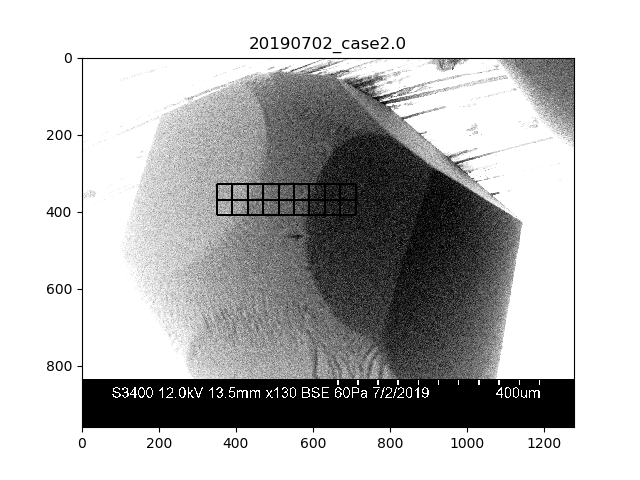

In [66]:
# Display
im = PIL.Image.open(Filename)

# Set up sub-grids in case of multiple segments
nyxgrid = []
for i in range(nsegments):
    nyxgridi = [ (y, x) for y in range(ny1list[i], ny2list[i]+1) for x in range(nx1list[i], nx2list[i]+1) ]
    nyxgrid.append(nyxgridi)

# Add the segments to the image
draw = PIL.ImageDraw.Draw(im)
for i in range(nsegments):
    nx1 = nx1list[i]
    nx2 = nx2list[i]
    ny1 = ny1list[i]
    ny2 = ny2list[i]
    ims.myrectangle(draw,(nx1,ny1),(nx2,ny2),5)

# Loop to evaluate the information content in each segment
infomatrix = np.matrix(np.zeros(shape=(4,4)))
percent = 100
for isegment in range(nsegments):
    nx1=nx1list[isegment]; nx2=nx2list[isegment]; nx = nx2-nx1+1
    ny1=ny1list[isegment]; ny2=ny2list[isegment]; ny = ny2-ny1+1
    cAseg = cA[nx1:nx2,ny1:ny2]; cAsegmean = np.mean(cAseg); print('<cA> =',cAsegmean)
    cBseg = cB[nx1:nx2,ny1:ny2]; cBsegmean = np.mean(cBseg); print('<cB> =',cBsegmean)
    cCseg = cC[nx1:nx2,ny1:ny2]; cCsegmean = np.mean(cCseg); print('<cC> =',cCsegmean)
    cDseg = cD[nx1:nx2,ny1:ny2]; cDsegmean = np.mean(cDseg); print('<cD> =',cDsegmean)
    cArel = cAseg - cAsegmean; cArel = cArel/np.std(cArel)
    cBrel = cBseg - cBsegmean; cBrel = cBrel/np.std(cBrel)
    cCrel = cCseg - cCsegmean; cCrel = cCrel/np.std(cCrel)
    cDrel = cDseg - cDsegmean; cDrel = cDrel/np.std(cDrel)
    infomatrix[0,0] = np.mean(cArel*cArel)
    infomatrix[0,1] = np.mean(cArel*cBrel)
    infomatrix[0,2] = np.mean(cArel*cCrel)
    infomatrix[0,3] = np.mean(cArel*cDrel)
    infomatrix[1,1] = np.mean(cBrel*cBrel)
    infomatrix[1,2] = np.mean(cBrel*cCrel)
    infomatrix[1,3] = np.mean(cBrel*cDrel)
    infomatrix[2,2] = np.mean(cCrel*cCrel)
    infomatrix[2,3] = np.mean(cCrel*cDrel)
    infomatrix[3,3] = np.mean(cDrel*cDrel)
    print('for segment ', isegment, 'correlation matrix is:')
    print(infomatrix*percent)

# This is to test the above idea
d1d2_list = []
for i in range(1000):
    d1 = np.random.randn(nacross,ndown); #print('d1=',d1)
    d2 = np.random.randn(nacross,ndown); #print('d2=',d2)
    d1d2 = np.mean(d1*d2); #print('random prediction = ', d1d2*percent)
    d1d2_list.append(d1d2)
print('Random prediction:', np.std(d1d2_list)*percent)
    
    
# Show it
plt.figure()
Iwantcontrast = True
if Iwantcontrast:
    updown = 40
    center = cAsegmean
    vmin = center-updown
    vmax = center+updown
else:
    vmin = 0
    vmax = 255
plt.imshow(np.asarray(im), cmap = 'Greys_r', vmin = vmin, vmax = vmax)
plt.title(imageroot)
    
# Save a copy
im.save(SEMSegmentjpgfile)

In [67]:
# Read and unpack the calibration data

# Just echo input data files  
print(Calibrationfile)

# Extract
Calibration=f90nml.read(Calibrationfile) #reads the file at a given path
pA=Calibration['Calibration']['pA']
pB=Calibration['Calibration']['pB']
pC=Calibration['Calibration']['pC']
pD=Calibration['Calibration']['pD']


Calibration.nml


In [68]:
# Set up a grid of surface normal vectors and the backscatter response on them
nptsx = 103
nptsy = 101
nxmid = int(nptsx/2); #print nxmid
nymid = int(nptsy/2); #print nymid
nmax = 5
nxi = np.linspace(-nmax,nmax,nptsx); dnx = nxi[1]-nxi[0]
nyi = np.linspace(-nmax,nmax,nptsy); dny = nyi[1]-nyi[0]
nxigrid,nyigrid = np.meshgrid(nxi,nyi)
theta = 15*np.pi/180
sA = (-nxigrid*np.sin(theta)+np.cos(theta)-1)/(1+nxigrid**2+nyigrid**2)**.5
sB = (-nyigrid*np.sin(theta)+np.cos(theta)-1)/(1+nxigrid**2+nyigrid**2)**.5
sC = (+nxigrid*np.sin(theta)+np.cos(theta)-1)/(1+nxigrid**2+nyigrid**2)**.5
sD = (+nyigrid*np.sin(theta)+np.cos(theta)-1)/(1+nxigrid**2+nyigrid**2)**.5

# Set up the grids     
BSgridA = np.polyval(pA,sA)
BSgridB = np.polyval(pB,sB)
BSgridC = np.polyval(pC,sC)
BSgridD = np.polyval(pD,sD)

In [69]:
# Generating the response function for each detector
BSgridN = [BSgridA, BSgridB, BSgridC, BSgridD]
BSgridL = ['A', 'B', 'C', 'D']
BSmax = 150 # this for display purposes
nxigrid.shape

(101, 103)

In [70]:
# Set up interpolators for detector responses
Arule, Brule, Crule, Drule, \
KAxrule, KAyrule, KBxrule, KByrule, KCxrule, KCyrule, KDxrule, KDyrule =\
fbs.setupdetectorresponse2(BSgridA, BSgridB, BSgridC, BSgridD, nxi, nyi, dnx, dny)

In [71]:
# Create a blank slate
solution = np.zeros(cA.shape)

In [72]:
# Generic retrieval parameters
maxiter = 5
tolerance = 10

In [73]:
# Create the a priori/solution set, and the uncertainty set
    
# Define the variance in the observations (BS units^2)
noiseamp = 5.0
print('Std deviation in input signal is', noiseamp**.5)

# Define parameters determining the variance in the a priori (microns^2)
apriorivar0 = 225.0

print('Std deviation in a priori is', apriorivar0**.5)

# Create the initial a priori variance
apriorivar = np.ones(cA.shape)*apriorivar0

# Create the initial a priori set
aprioriset = np.zeros(cA.shape)

Std deviation in input signal is 2.23606797749979
Std deviation in a priori is 15.0


In [74]:
# Loop to retrieve each segment
for isegment in range(nsegments):
    
    # Choose the particular location of the dataset to analyze
    nx1=nx1list[isegment]; nx2=nx2list[isegment]; nx = nx2-nx1+1
    ny1=ny1list[isegment]; ny2=ny2list[isegment]; ny = ny2-ny1+1

    # Construct gradients
    Ny_unscaled, Nx_unscaled = gds.makeNxNy(ny,nx)
    Ny = Ny_unscaled/dy
    Nx = -Nx_unscaled/dx #fixing x inversion
    
    # Number of observations
    nobs = (nx-1)*(ny-1)*4

    # Number of desired points (heights)
    nzpts = ny*nx-1
    
    # Extract the a priori variance
    vartemp = apriorivar[ny1:ny2+1,nx1:nx2+1]
    vartemp_long = np.reshape(vartemp,nzpts+1,0)
    Sa = np.diag(vartemp_long[:-1]); #print "apriorivar", shape(Sa)
    
    # Extract the starting z
    settemp = solution[ny1:ny2+1,nx1:nx2+1]
    settemp_long = np.reshape(settemp,nzpts+1,0)
    settemp_longminus1 = settemp_long[:-1]
    z_start = np.matrix(settemp_longminus1).T; #print "aprioriset", shape(z_start)
    z_start = z_start*0.0; #print "aprioriset", shape(z_start)

    # Construct the variance in observation + model
    Se = np.matrix(np.eye(nobs))*noiseamp # Variance in observation + model (c)

    # Do the retrieval
    print('')
    print("for", nx1, ny1)
    print("Segment:", isegment+1, "of", nsegments)
    z_retrieved = fbs.retrievesegment(\
        nx1,ny1,nx2,ny2,cA,cB,cC,cD,\
        Sa,Se,z_start,maxiter,tolerance,\
        Nx,Ny,\
        Arule, Brule, Crule, Drule,\
        KAxrule, KAyrule, \
        KBxrule, KByrule, \
        KCxrule, KCyrule, \
        KDxrule, KDyrule)
    
    if isegment == 0:
        solution[ny1:ny2+1,nx1:nx2+1] = copy.copy(z_retrieved)
    else:
        nextsolution = np.zeros(cA.shape)
        nextsolution[ny1:ny2+1,nx1:nx2+1] = copy.copy(z_retrieved)
        overlap = []
        for i in range(isegment):
            nextoverlap = list( set(nyxgrid[i])&set(nyxgrid[isegment]) )
            overlap = overlap + nextoverlap
            Noverlap = len(overlap); 
        print("Noverlap =", Noverlap)
        diff = 0.0
        for j in range(Noverlap):
            diff += nextsolution[overlap[j]] - solution[overlap[j]]
        diffavg = diff/Noverlap
        z_retrieved -= diffavg
        solution[ny1:ny2+1,nx1:nx2+1] = copy.copy(z_retrieved)


for 350 330
Segment: 1 of 18
Observed intensities (detector B):
mean, max, min = 20.670625 38.0 4.0
<diff>, std(diff), di2 = 6.438570820858318 28.561030164372884 1070992.5914763208
<diff>, std(diff), di2 = 1.3872709979359783 8.92753228813439 79146.19723958765
<diff>, std(diff), di2 = -0.07502321624239876 5.322648828976124 9269.035085385945
<diff>, std(diff), di2 = -0.7337965209411946 4.52343573209605 488.0369071771113
<diff>, std(diff), di2 = -0.8648124033164554 4.413636757511923 27.133291978871238

for 350 370
Segment: 2 of 18
Observed intensities (detector B):
mean, max, min = 21.82875 40.0 4.0
<diff>, std(diff), di2 = 6.8743520708583175 28.245651444578275 1053184.2198739098
<diff>, std(diff), di2 = 1.927277638633296 8.734667121366888 78260.75568953539
<diff>, std(diff), di2 = 0.48983798128496536 5.174607545569534 9309.014879376391
<diff>, std(diff), di2 = -0.16525370072668483 4.427221959515191 498.5163660252647
<diff>, std(diff), di2 = -0.30900279994014185 4.327578883929113 26.3089

360
80


<IPython.core.display.Javascript object>


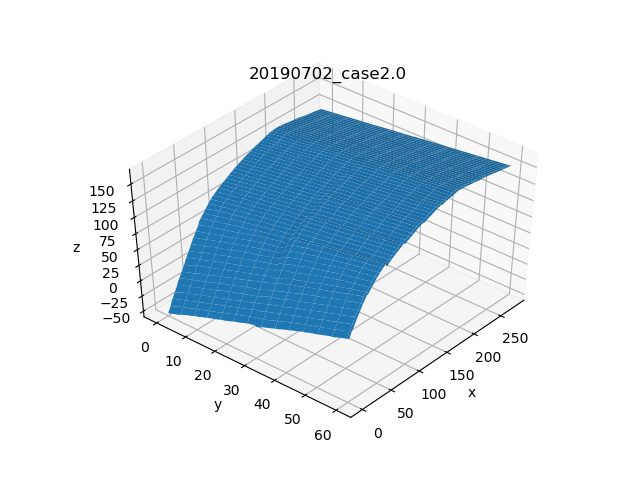

In [75]:
# Show the reconstructed surface
nx1tot = min(nx1list)
nx2tot = max(nx2list)
ny1tot = min(ny1list)
ny2tot = max(ny2list)
nxtot = nx2tot-nx1tot; print (nxtot)
nytot = ny2tot-ny1tot; print (nytot)
ymaxtot = (nytot-1)*dy; xmaxtot = (nxtot-1)*dx

surf_ytot = np.linspace(0,ymaxtot,nytot); #print surf_ytot[1]-surf_ytot[0]; 
surf_xtot = np.linspace(0,xmaxtot,nxtot); #print surf_xtot[1]-surf_xtot[0]; 
surf_xgridtot, surf_ygridtot = np.meshgrid(surf_xtot,surf_ytot)
settemp = solution[ny1tot:ny2tot,nx1tot:nx2tot]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(surf_xgridtot, surf_ygridtot, settemp, rstride=6,cstride=6)
ax.invert_yaxis() # invert y axis (this fixes the right-hand-oriented vs left-hand-oriented system)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title(imageroot)
ax.view_init(azim=-120,elev=22)

In [76]:
# Save this data

#save an image
fig.savefig(Retrievedjpgfile)


print("saving", Compressedfilename)
np.savez_compressed(Compressedfilename, \
                    surfaceroot=imageroot, \
                    imageroot=imageroot, \
                    nx1list=nx1list, \
                    nx2list=nx2list, \
                    ny1list=ny1list, \
                    ny2list=ny2list, \
                    pA=pA, \
                    pB=pB, \
                    pC=pC, \
                    pD=pD, \
                    sA=sA, \
                    sB=sB, \
                    sC=sC, \
                    sD=sD, \
                    nxi=nxi, \
                    nyi=nyi, \
                    dnx=dnx, \
                    dny=dny, \
                    solution=solution)

saving Segments6_retrieved
